In [ ]:
import mne
edf_path = "../data/physionet.org/files/chbmit/1.0.0/chb01/chb01_01.edf"
raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
raw.info

Extracting EDF parameters from c:\Users\noors\Desktop\School\Project\Python Project\Data Science Project\seizure_forecasting\data\physionet.org\files\chbmit\1.0.0\chb01\chb01_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\noors\AppData\Local\Temp\ipykernel_19896\3101894702.py:3: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


<Info | 8 non-empty values
 bads: []
 ch_names: FP1-F7, F7-T7, T7-P7, P7-O1, FP1-F3, F3-C3, C3-P3, P3-O1, ...
 chs: 23 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: 2076-11-06 11:42:54 UTC
 nchan: 23
 projs: []
 sfreq: 256.0 Hz
 subject_info: <subject_info | his_id: Surrogate>
>

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (6.605 s)

Using matplotlib as 2D backend.


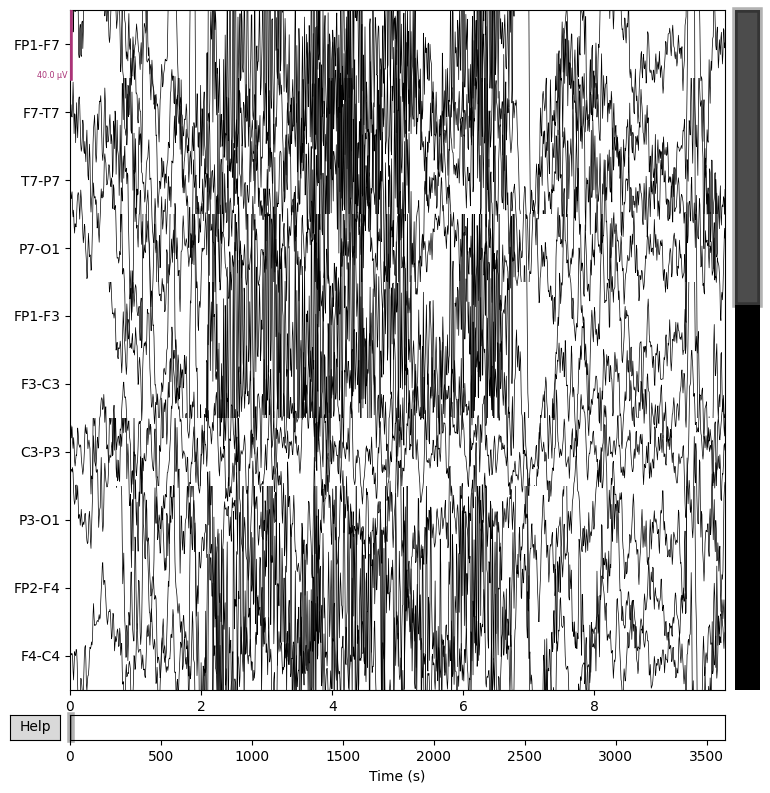

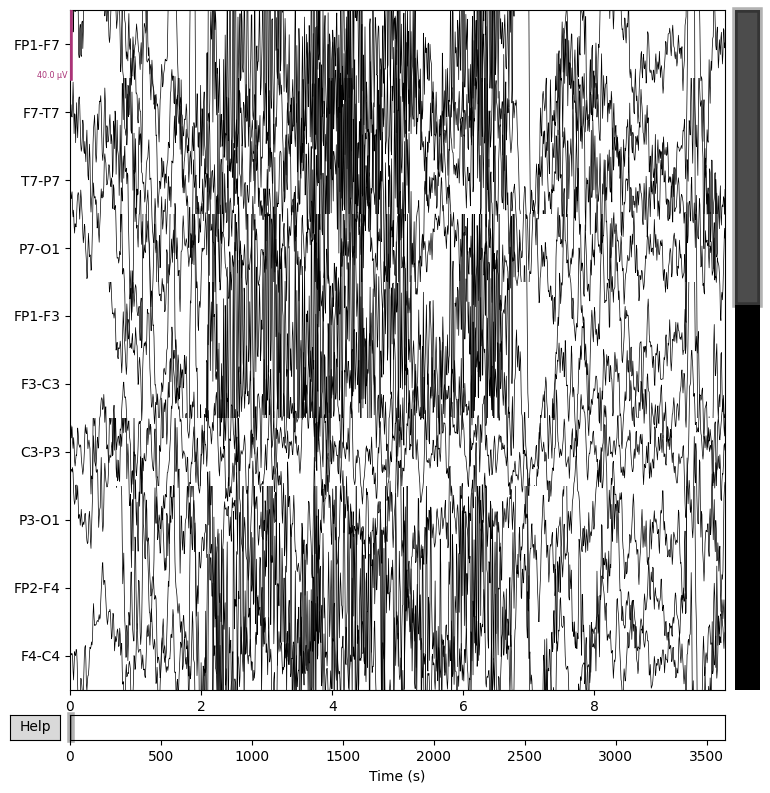

In [2]:
# Apply band-pass filter (0.5–40 Hz)
raw.filter(0.5, 40., fir_design='firwin')

# Downsample to 128 Hz
raw.resample(128)

# Plot a short segment (first 10 seconds, 10 channels)
raw.plot(duration=10, n_channels=10)

In [3]:
import numpy as np

# Extract the data and channel names
data, times = raw.get_data(return_times=True)
print("EEG shape:", data.shape)
print("Time duration (s):", times[-1])

EEG shape: (23, 460800)
Time duration (s): 3599.9921875


In [4]:
def create_windows(data, sfreq=128, window_size=30, stride=10):
    samples_per_window = int(window_size * sfreq)
    step = int(stride * sfreq)
    windows = []
    for start in range(0, data.shape[1] - samples_per_window, step):
        end = start + samples_per_window
        windows.append(data[:, start:end])
    return np.array(windows)

# Create windows (30s window, 10s stride)
windows = create_windows(data, sfreq=128, window_size=30, stride=10)
print("Windows shape:", windows.shape)

Windows shape: (357, 23, 3840)


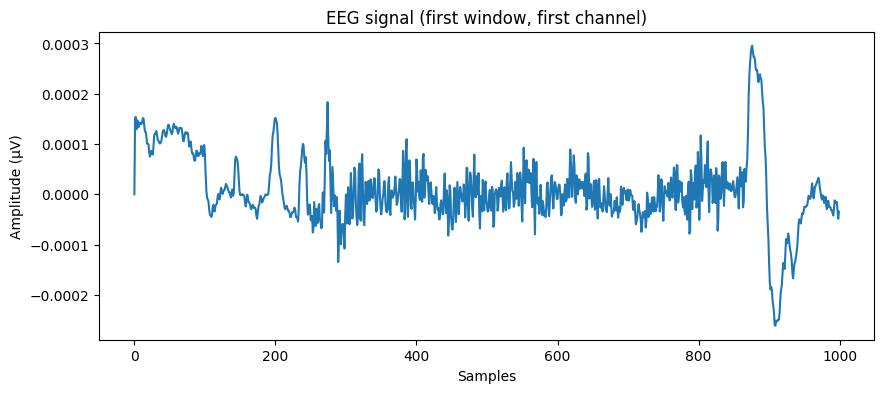

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(windows[0][0][:1000])  # first channel, 1000 samples (~8 seconds)
plt.title("EEG signal (first window, first channel)")
plt.xlabel("Samples")
plt.ylabel("Amplitude (µV)")
plt.show()

In [ ]:
import re
import numpy as np
import pandas as pd

# Path to your summary file (update this with your actual path)
summary_file = "../data/physionet.org/files/chbmit/1.0.0/chb01/chb01-summary.txt"

# Read summary file
with open(summary_file, "r") as f:
    summary_text = f.read()

# Extract seizure intervals for each record using regex
pattern = r"File Name: (\S+\.edf).*?Seizure Start Time: (\d+) seconds.*?Seizure End Time: (\d+) seconds"
matches = re.findall(pattern, summary_text, re.DOTALL)

# Store seizure intervals in a dictionary
seizure_dict = {}
for file_name, start, end in matches:
    if file_name not in seizure_dict:
        seizure_dict[file_name] = []
    seizure_dict[file_name].append((int(start), int(end)))

print("Extracted seizure intervals:")
for k, v in seizure_dict.items():
    print(f"{k}: {v}")

# Example: labeling for one EDF file
edf_name = "chb01_03.edf"  # change this to match your loaded file
seizure_intervals = seizure_dict.get(edf_name, [])

# Label creation
window_size = 3840 / 256  # 15 seconds
window_starts = np.arange(0, len(windows)) * window_size
labels = np.zeros(len(windows))

for start, end in seizure_intervals:
    for i, win_start in enumerate(window_starts):
        win_end = win_start + window_size
        if (win_start < end) and (win_end > start):
            labels[i] = 1

labels_df = pd.DataFrame({
    "window_index": np.arange(len(windows)),
    "start_time_sec": window_starts,
    "label": labels
})

print(labels_df.head(10))
print(f"Seizure windows: {np.sum(labels==1)}, Non-seizure: {np.sum(labels==0)}")

Extracted seizure intervals:
chb01_01.edf: [(2996, 3036)]
chb01_04.edf: [(1467, 1494)]
chb01_05.edf: [(1732, 1772)]
chb01_16.edf: [(1015, 1066)]
chb01_17.edf: [(1720, 1810)]
chb01_19.edf: [(327, 420)]
chb01_22.edf: [(1862, 1963)]
   window_index  start_time_sec  label
0             0             0.0    0.0
1             1            15.0    0.0
2             2            30.0    0.0
3             3            45.0    0.0
4             4            60.0    0.0
5             5            75.0    0.0
6             6            90.0    0.0
7             7           105.0    0.0
8             8           120.0    0.0
9             9           135.0    0.0
Seizure windows: 0, Non-seizure: 357
